# **FYP: ML Based Anomaly Detection in Bitcoin (BTCSleuth)**  



---


In [161]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import matplotlib.gridspec as gridspec


In [162]:
# Preprocessing 
df = pd.read_csv("Dataset/Dataset.csv") 

df.ffill(inplace=True)

# Optional: Convert timestamp if it exists
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define the features and the anomaly label column
features = ['Weight Mean', 'Difficulty Mean', 'Reward Mean',
            'Transaction Sum', 'Total Blocks', 'Fee Total Sum']
label = 'Anomaly' # The column name for your anomaly labels

# Check if the required columns exist
if not all(col in df.columns for col in features + [label]):
    missing_cols = [col for col in features + [label] if col not in df.columns]
    print(f"Error: Missing required columns in the dataset: {missing_cols}")
    exit()


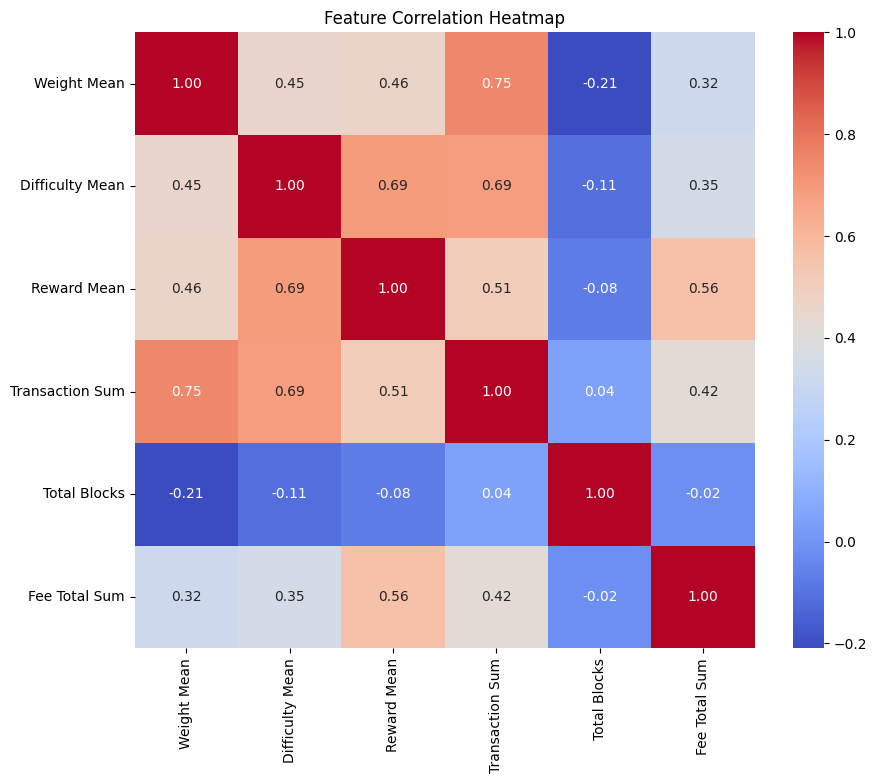

In [163]:
# %%
# Define features/labels
X = df[features]
y = df[label]

# %%
# Add the heatmap code here
# Calculate the correlation matrix of the features
correlation_matrix = X.corr()

# Create the heatmap
plt.figure(figsize=(10, 8)) # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.savefig("Outputml/heatmap.png")
plt.show()

# %%
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)




In [164]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [165]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved successfully!")

Scaler saved successfully!


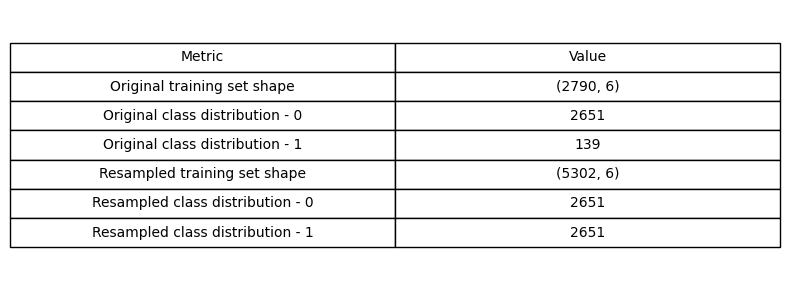

In [166]:
orig_shape = X_train.shape
orig_counts = y_train.value_counts()

# 3️⃣ Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 4️⃣ Resampled distribution
res_shape = X_train_bal.shape
res_counts = y_train_bal.value_counts()

# 5️⃣ Make DataFrame for display
data = {
    "Metric": [
        "Original training set shape",
        "Original class distribution - 0",
        "Original class distribution - 1",
        "Resampled training set shape",
        "Resampled class distribution - 0",
        "Resampled class distribution - 1"
    ],
    "Value": [
        str(orig_shape),
        str(orig_counts.get(0, 0)),
        str(orig_counts.get(1, 0)),
        str(res_shape),
        str(res_counts.get(0, 0)),
        str(res_counts.get(1, 0))
    ]
}

df_report = pd.DataFrame(data)

# 6️⃣ Plot as table
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
table = ax.table(cellText=df_report.values,
                 colLabels=df_report.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()

# 7️⃣ Save to Outputml
plt.savefig("Outputml/SMOTE_Report_Table.png", dpi=300)
plt.show()

In [167]:
# Initialize a dictionary to store the model metrics
model_metrics = {}

In [168]:
# Function to compute and store metrics
def compute_metrics(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Add new metrics
    try:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Get probabilities for the positive class (assuming binary classification)
        auc = roc_auc_score(y_test, y_pred_proba)
    except AttributeError:
        print(f"Warning: Model {type(model).__name__} does not support predict_proba for AUC calculation.")
        auc = None

    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    return accuracy, precision, recall, f1, cm, auc, balanced_accuracy

In [169]:
# SVM Training
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm.fit(X_train_bal, y_train_bal)
svm_metrics = compute_metrics(svm, X_test_scaled, y_test)
model_metrics['SVM'] = svm_metrics

# Save the SVM model
joblib.dump(svm, 'svm_model.pkl')
print("SVM model saved successfully!")

SVM model saved successfully!


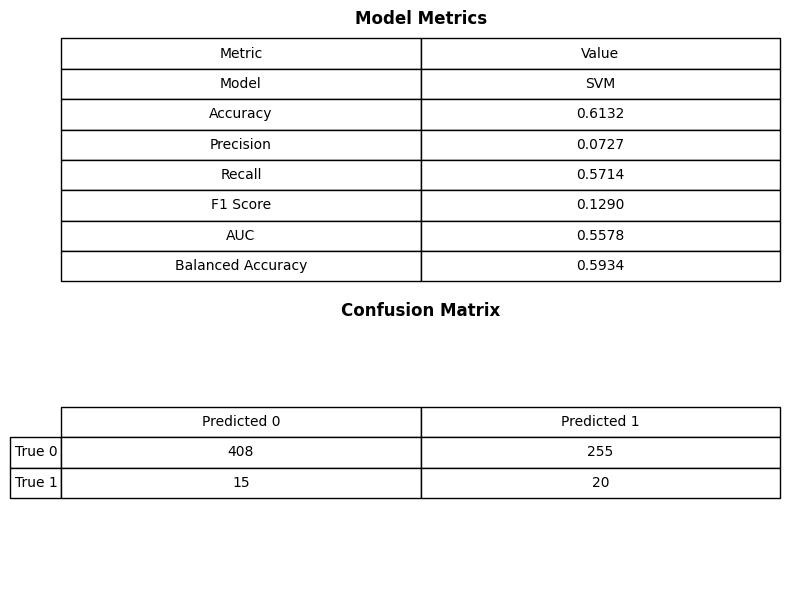

In [170]:
# Displaying the metrics for each model trained so far (SVM)
# Loop through each model's metrics
for model_name, metrics in model_metrics.items():
    # Unpack
    accuracy, precision, recall, f1, cm, auc, balanced_accuracy = metrics

    # Metrics dictionary for DataFrame
    metrics_data = {
        "Metric": [
            "Model",
            "Accuracy",
            "Precision",
            "Recall",
            "F1 Score",
            "AUC" if auc is not None else None,
            "Balanced Accuracy"
        ],
        "Value": [
            model_name,
            f"{accuracy:.4f}",
            f"{precision:.4f}",
            f"{recall:.4f}",
            f"{f1:.4f}",
            f"{auc:.4f}" if auc is not None else None,
            f"{balanced_accuracy:.4f}"
        ]
    }

    # Remove None rows (if AUC wasn't calculated)
    df_metrics = pd.DataFrame(metrics_data).dropna()

    # Confusion matrix as DataFrame
    df_cm = pd.DataFrame(
        cm,
        columns=["Predicted 0", "Predicted 1"],
        index=["True 0", "True 1"]
    )

    # Create figure with 2 tables: metrics + CM
    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

    # --- Metrics table
    ax0 = plt.subplot(gs[0])
    ax0.axis('off')
    table_metrics = ax0.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc='center',
        loc='center'
    )
    table_metrics.auto_set_font_size(False)
    table_metrics.set_fontsize(10)
    table_metrics.scale(1, 1.5)
    ax0.set_title('Model Metrics', fontweight='bold')

    # --- Confusion Matrix table
    ax1 = plt.subplot(gs[1])
    ax1.axis('off')
    table_cm = ax1.table(
        cellText=df_cm.values,
        rowLabels=df_cm.index,
        colLabels=df_cm.columns,
        cellLoc='center',
        loc='center'
    )
    table_cm.auto_set_font_size(False)
    table_cm.set_fontsize(10)
    table_cm.scale(1, 1.5)
    ax1.set_title('Confusion Matrix', fontweight='bold')

    plt.tight_layout()

    # Save image per model
    filename = f"Outputml/{model_name}_Report_Table.png"
    plt.savefig(filename, dpi=300)
    plt.show()

In [171]:
# Random Forest Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
rf_metrics = compute_metrics(rf_model, X_test_scaled, y_test)
model_metrics['Random Forest'] = rf_metrics

# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved successfully!")

Random Forest model saved successfully!


In [172]:
# Displaying the metrics for each model trained so far (SVM, Random Forest)
for model_name, metrics in model_metrics.items():
    # Unpack the metrics including the new ones
    accuracy, precision, recall, f1, cm, auc, balanced_accuracy = metrics

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print the new metrics if they were calculated
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    print(f"Confusion Matrix:\n{cm}")
    print("\n")

Model: SVM
Accuracy: 0.6132
Precision: 0.0727
Recall: 0.5714
F1 Score: 0.1290
AUC: 0.5578
Balanced Accuracy: 0.5934
Confusion Matrix:
[[408 255]
 [ 15  20]]


Model: Random Forest
Accuracy: 0.8926
Precision: 0.0833
Recall: 0.1143
F1 Score: 0.0964
AUC: 0.5087
Balanced Accuracy: 0.5240
Confusion Matrix:
[[619  44]
 [ 31   4]]




In [173]:

# AdaBoost Classifier Training
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train_bal, y_train_bal)
ada_metrics = compute_metrics(ada_model, X_test_scaled, y_test)
model_metrics['AdaBoost'] = ada_metrics

# Save the AdaBoost model
joblib.dump(ada_model, 'adaboost_model.pkl')
print("AdaBoost model saved successfully!")

AdaBoost model saved successfully!


In [ ]:
# Displaying the metrics for each model trained so far (SVM, Random Forest, AdaBoost)
for model_name, metrics in model_metrics.items():
    # Unpack the metrics including the new ones
    accuracy, precision, recall, f1, cm, auc, balanced_accuracy = metrics

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print the new metrics if they were calculated
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    print(f"Confusion Matrix:\n{cm}")
    print("\n")

In [175]:
# XGBoost Classifier Training
xg_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xg_model.fit(X_train_bal, y_train_bal)
xg_metrics = compute_metrics(xg_model, X_test_scaled, y_test)
model_metrics['XGBoost'] = xg_metrics

# Save the XGBoost model
joblib.dump(xg_model, 'xgboost_model.pkl')
print("XGBoost model saved successfully!")

XGBoost model saved successfully!


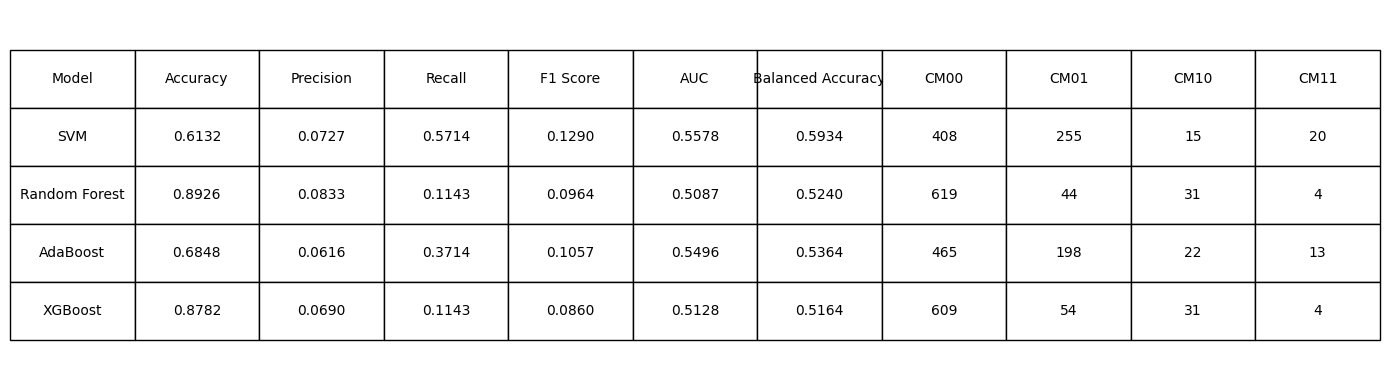

In [184]:

# ✅ 1️⃣ Collect all model data in one table
all_models_data = []

for model_name, metrics in model_metrics.items():
    accuracy, precision, recall, f1, cm, auc, balanced_accuracy = metrics

    # Unpack confusion matrix cells
    cm00 = cm[0][0]
    cm01 = cm[0][1]
    cm10 = cm[1][0]
    cm11 = cm[1][1]
    
    # Add all to row
    row = {
        "Model": model_name,
        "Accuracy": f"{accuracy:.4f}",
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1 Score": f"{f1:.4f}",
        "AUC": f"{auc:.4f}" if auc is not None else "-",
        "Balanced Accuracy": f"{balanced_accuracy:.4f}",
        "CM00": cm00,
        "CM01": cm01,
        "CM10": cm10,
        "CM11": cm11
    }
    
    all_models_data.append(row)

# ✅ 2️⃣ Build big DataFrame
df_all_models = pd.DataFrame(all_models_data)

# ✅ 3️⃣ Make image of whole table
plt.figure(figsize=(14, 2 + len(df_all_models)*0.5))
plt.axis('off')

table = plt.table(
    cellText=df_all_models.values,
    colLabels=df_all_models.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 2.9)

plt.tight_layout()

# ✅ 4️⃣ Save to one single image
plt.savefig("Outputml/All_Models_Full_Report_Table.png", dpi=300)
plt.show()


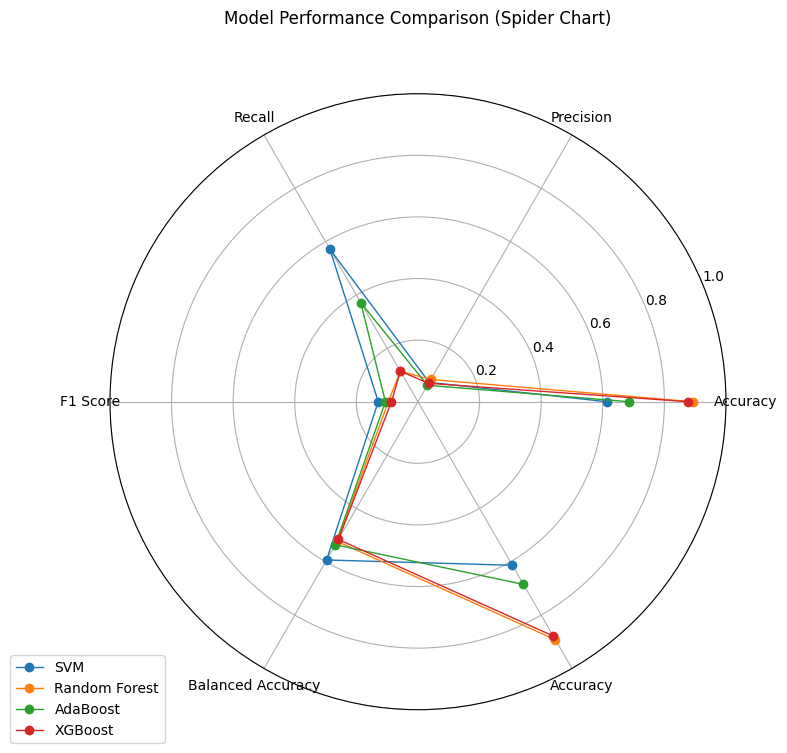

In [177]:
# Spider chart for Model Performance Comparison
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data for the spider chart
data = {}
for model_name, metrics in model_metrics.items():
    # Unpack the metrics - ensure you have all the metrics you want to plot
    accuracy, precision, recall, f1, cm, auc, balanced_accuracy = metrics
    # Select the metrics you want to include in the spider chart
    # Make sure the order matches the metrics_names list below
    data[model_name] = [accuracy, precision, recall, f1, balanced_accuracy]

df_spider = pd.DataFrame(data)

# Define the names of the metrics that will be used as axes
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Balanced Accuracy']

# Add a duplicate of the first metric's values to the end of the DataFrame
# This is needed to close the spider chart
df_spider = pd.concat([df_spider, df_spider.iloc[[0]]])
# Add the name of the first metric to the end of the list
metrics_names.append(metrics_names[0])

# Calculate the angles for each axis in radians
# There will be one angle for each metric (including the duplicated one)
angles = [n / float(len(metrics_names)) * 2 * np.pi for n in range(len(metrics_names))]

# Convert angles to a NumPy array for element-wise mathematical operations
angles_np = np.array(angles)

# Create the polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Set the maximum value for the radial axis (0 to 1 for these metrics)
ax.set_ylim(0, 1)

# Plot each model's performance on the spider chart
for model_name in df_spider.columns:
    # Plot the metric values against the calculated angles
    ax.plot(angles_np, df_spider[model_name], marker='o', linestyle='-', linewidth=1, label=model_name)

# Set the labels for each axis (metric names)
# Convert angles from radians to degrees for display
ax.set_thetagrids(angles_np * 180/np.pi, metrics_names)

# Add a title to the spider chart
ax.set_title("Model Performance Comparison (Spider Chart)", y=1.1)

# Add a grid to the plot
ax.grid(True)

# Add a legend to identify each model's line
# Position the legend appropriately
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig("Outputml/Spider.png")
# Display the plot
plt.show()




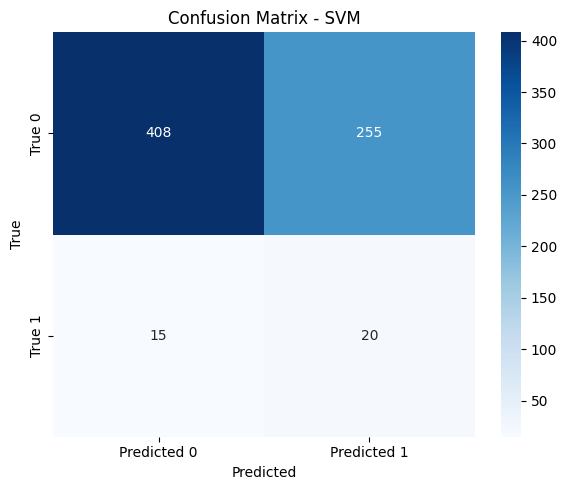

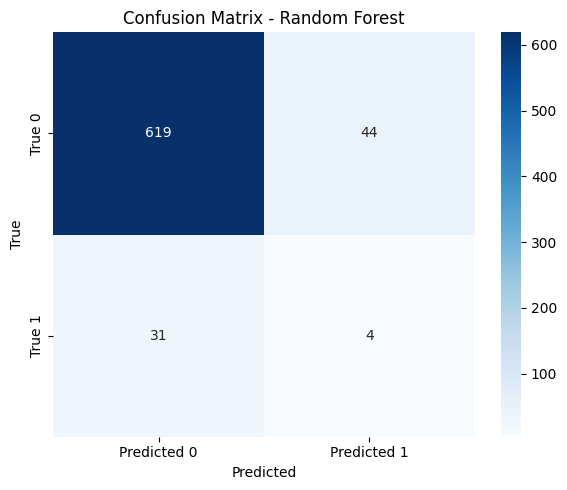

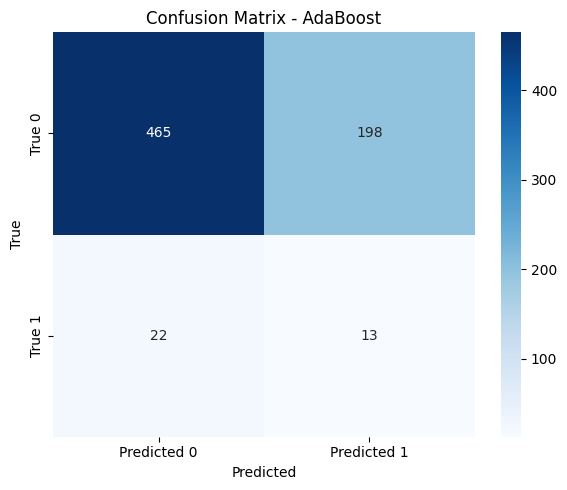

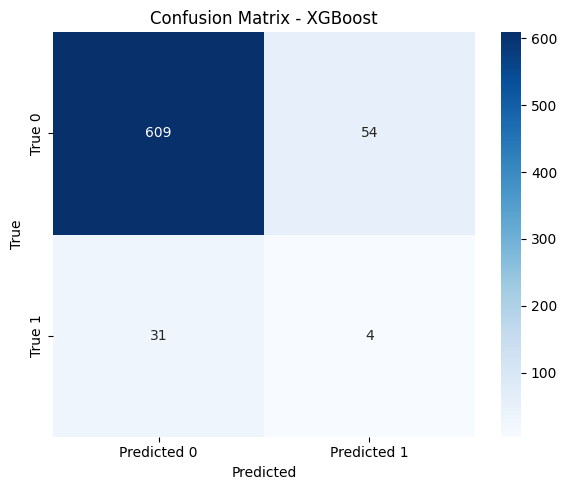

In [178]:
# Plotting Confusion Matrices
for model_name, metrics in model_metrics.items():
    cm = metrics[4]
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['True 0', 'True 1']
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

    # Save with model name
    filename = f"Outputml/CFMatrix_{model_name}.png"
    plt.savefig(filename)

    

    plt.show()
    


In [179]:
# The following section demonstrates how to load saved models and scaler
# and make predictions on new, unseen data (e.g., from a different source)

# Load the trained models
try:
    svm_loaded = joblib.load('svm_model.pkl')
    rf_loaded = joblib.load('random_forest_model.pkl')
    ada_loaded = joblib.load('adaboost_model.pkl')
    xg_loaded = joblib.load('xgboost_model.pkl')
    scaler_loaded = joblib.load('scaler.pkl')
    print("\nModels and scaler loaded successfully!")
except FileNotFoundError:
    print("\nError loading models or scaler. Please ensure they were saved correctly.")

# Function to preprocess incoming real-time data (using the loaded scaler)
def preprocess_data_for_prediction(transaction_data):
    # Assuming transaction_data is a dictionary or DataFrame representing one or more transactions
    if isinstance(transaction_data, dict):
        transaction_df = pd.DataFrame([transaction_data])  # Convert dict to DataFrame
    elif isinstance(transaction_data, pd.DataFrame):
        transaction_df = transaction_data
    else:
        raise ValueError("Input data must be a dictionary or pandas DataFrame.")

    # Feature extraction (use the same features as during training)
    features_for_pred = ['Weight Mean', 'Difficulty Mean', 'Reward Mean',
                         'Transaction Sum', 'Total Blocks', 'Fee Total Sum']

    # Check if required features are in the input data
    if not all(col in transaction_df.columns for col in features_for_pred):
         missing_cols_pred = [col for col in features_for_pred if col not in transaction_df.columns]
         raise ValueError(f"Missing required features for prediction: {missing_cols_pred}")


    # Extract the relevant features
    transaction_features = transaction_df[features_for_pred]

    # Normalize the features using the loaded scaler
    transaction_scaled = scaler_loaded.transform(transaction_features)

    return transaction_scaled

# Function to predict anomalies using loaded models (ensemble prediction)
def predict_anomaly_ensemble(transaction_data):
    # Preprocess the incoming data
    transaction_scaled = preprocess_data_for_prediction(transaction_data)

    # Predict with each loaded model
    svm_pred = svm_loaded.predict(transaction_scaled)
    rf_pred = rf_loaded.predict(transaction_scaled)
    ada_pred = ada_loaded.predict(transaction_scaled)
    xg_pred = xg_loaded.predict(transaction_scaled)

    # Combine the predictions (using majority voting for simplicity)
    # For a single transaction, predictions will be an array of length 1 for each model
    predictions = np.array([svm_pred, rf_pred, ada_pred, xg_pred]).flatten() # Flatten to a 1D array

    # Perform majority vote
    # If there's a tie, np.bincount().argmax() will return the smallest index (0 in this case)
    # This might favor the 'normal' class in a tie
    anomaly_detected = np.bincount(predictions.astype(int)).argmax()

    return anomaly_detected  # 1 indicates anomaly, 0 indicates normal

# --- Example of using the ensemble prediction function ---

# Simulate new real-time data for prediction
# You can replace this with data loaded from another source or real-time feed
sample_transaction_new = {
    'Weight Mean': 3.6,
    'Difficulty Mean': 4.3,
    'Reward Mean': 0.85,
    'Transaction Sum': 160000, # Example of a value that might be normal
    'Total Blocks': 102,
    'Fee Total Sum': 1050
}

# Predict anomaly in the sample transaction
anomaly_prediction = predict_anomaly_ensemble(sample_transaction_new)

print("\n--- Ensemble Prediction on a Sample Transaction ---")
if anomaly_prediction == 1:
    print("Anomaly detected: Potential abnormal behavior!")
else:
    print("Transaction is predicted as normal.")

# You can also test on a sample that should be anomalous based on your injected anomalies
# For example, if you injected anomalies by increasing 'Transaction Sum' significantly
sample_anomalous_transaction = {
    'Weight Mean': 3.5,
    'Difficulty Mean': 4.2,
    'Reward Mean': 0.8,
    'Transaction Sum': 500000, # Example of a significantly higher value
    'Total Blocks': 100,
    'Fee Total Sum': 1000
}

anomaly_prediction_anomalous = predict_anomaly_ensemble(sample_anomalous_transaction)

print("\n--- Ensemble Prediction on a Sample Anomalous Transaction ---")
if anomaly_prediction_anomalous == 1:
    print("Anomaly detected: Potential abnormal behavior!")
else:
    print("Transaction is normal.")


Models and scaler loaded successfully!

--- Ensemble Prediction on a Sample Transaction ---
Transaction is predicted as normal.

--- Ensemble Prediction on a Sample Anomalous Transaction ---
Transaction is normal.
